In [1]:
#[220505_1137]UPDATED 지금까지 구성을 전부 정리함
from Bio import Entrez, SeqIO, AlignIO
from Bio.Align.Applications import MuscleCommandline
from pathlib import Path
from Bio import GenBank
from Bio.SeqUtils import GC

Entrez.email = "nagabuti13@naver.com"

#[220502_1717]CREATED getIdList: NCBI에서 keyword를 검색하여 script의 id를 추출한다
#[220512_1210]NOTED esearch()의 파라미터에 id의 개수를 조절하는 retmax 파라미터가 존재
def getIdlist(database, keyword):
    handle = Entrez.esearch(db = database, retmax = 10000, term = keyword)
    records = Entrez.read(handle)
    return records["IdList"]

#[220505_1717]CREATED getFastaFile: NCBI에서 id를 검색하여 얻은 fasta파일을 컴퓨터에 저장한다
def getFasta(id):
    handle = Entrez.efetch(db = 'nucleotide', id = id, rettype = 'fasta', retmode = 'text')
    record = SeqIO.read(handle, 'fasta')
    print('## creating ' + record.id + '.fasta...')
    with open(record.id + '.fasta', 'w') as f:
        f.write('>' + record.description + '\n')
        f.write(str(record.seq) + '\n')
    
#[220502_1717]CREATED getAlnFile: 다중염기서열을 생성하는 툴 중 하나인 MUSCLE로 aln파일을 생성한다
def getAln(filename):
    muscle_exe = '/Users/kimjoonsu/muscle3.8.31_i86darwin64'
    cmd_line = MuscleCommandline(muscle_exe, input = filename,
                             out = Path(filename).stem + '.aln', clw = ' ')
    print(cmd_line)
    stdout, stderr = cmd_line()   
    
#[220509_1517]CREATED ncbi에서 alignment의 각 record genbank파일로부터 종 이름을 반환
def getGenbank(id):
    handle = Entrez.efetch(db = "nucleotide", rettype = "gb", id = id, retmode = "text")
    r = GenBank.read(handle)
    #[220811_1431]NOTED getOrganism() -> getGenbank()
    return r

In [9]:
getAln('all_big_coi_2.fasta')

/Users/kimjoonsu/muscle3.8.31_i86darwin64 -in all_big_coi_2.fasta -out all_big_coi_2.aln -clw


In [4]:
from Bio import AlignIO

alignment = AlignIO.read('all_big_coi_2.aln', 'clustal')
length = []
count = 0
start, end = 0, 0
k = 3
mer = ''
for record in alignment:
    count = 0
    for i in range(len(record.seq)):
        mer = record.seq[i:i + k]
        if(count == 1 and mer.count('-') == 2):
            end = i
            break
        elif(mer.count('-') == 3):
            continue
        elif(count != 1):
            start = i + k - 1
            count = 1
    length.append(end - start + 1)

In [5]:
#[220508_1659]CREATED Sequecne Alignment를 다룰 수 있는 모듈 호출
from Bio import AlignIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans

alignment = AlignIO.read('all_big_coi_2.aln', 'clustal')

k = 3
dict = {}
df = pd.DataFrame()
#[220513_1700]CREATED AGCT 외의 염기를 처리하기 위해 사전형에 key, value로 저장 
base_dict = {'A':'A', 'G':'G', 'C':'C', 'T':'T', 'U':'U',
'Y':'T', 'R':'A', 'S':'C', 'W':'A', 'K':'G', 'M':'C', 'B':'C', 'D':'G', 'H':'T', 'V':'C', 'N':'A'}

#[220508_1735]CREATED k = 3인 kmer의 모든 경우의 수를 사전형에 미리 저장
def init(datatype):
    for i in range(4):
        for j in range(4):
            for k in range(4):
                datatype[list(base_dict.keys())[i] + list(base_dict.keys())[j] + list(base_dict.keys())[k]] = 0
    #datatype['---'] = 0
    #[220509_1517]CREATED k-means는 unsupervised이지만, 여기서는 표본의 타겟을 ncbi에서부터 추출가능하므로 타겟 피처 생성
    datatype['target'] = 0

init(df)

#[220508_1738]CREATED 'all.aln' 안의 모든 개체의 염기서열을 k = 3인 kmers로 구분짓고 빈도를 사전에 저장
for i, record in enumerate(alignment):
    init(dict)
    #[220509_1517]NOTED getOrganism() 호출
    dict['target'] = getGenbank(record.id).organism
    index = 0
    if(len(record.seq[61:578]) >= k):
        while(index + k <= 517):
            mer = record.seq[61:578][index:index + k]
            if(mer.find('-') != -1):
                #dict['---'] += 1
                index += 1
                continue
            #[220513_1810]CREATED kmer 문자열을 base_dict의 values로 교체
            for p in range(k):
                mer = mer.replace(mer[p], base_dict.get(mer[p]))
                
            dict[mer] += 1
            index += 1
    df.loc[i] = dict
    
#[220508_2232]NOTED 총 문자열 길이를 L이라 하면, kmers의 개수: L - k + 1 ex) 1542 - 3 + 1 = 1540개
#[220513_1623]NOTED 1542 -> 17377(하나의 시퀀스의 실제 길이: 약 600bp이지만 MSA의 경우 '-'로 인해 길어져 보인다.)

In [6]:
#[220509_1621]CREATED 레이블 인코딩으로 종 이름 -> 고유 숫자
from sklearn.preprocessing import LabelEncoder

a = df['target']
encoder = LabelEncoder()
labels = encoder.fit_transform(a)
#[220509_1622]NOTED* 종의 총 개수 = 19인 것을 알 수 있으므로 KMeans의 파라미터인 n_clusters를 14 -> 19로 수정
#[220513_1830]NOTED 종: 101개
#[220519_1745]NOTED 종: 9개
print(labels)

df['target'] = labels
df.head()

[6 6 6 3 0 1 1 1 5 5 5 5 7 7 7 7 7 7 7 7 7 7 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 0 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3]


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,target
0,5,3,3,8,3,7,6,6,12,2,...,4,4,1,3,8,11,8,7,9,6
1,5,3,2,7,3,10,5,6,10,2,...,4,8,3,4,8,6,6,10,7,6
2,5,3,2,7,3,10,5,6,10,2,...,4,8,3,4,8,6,6,10,7,6
3,16,4,6,11,6,3,7,3,5,0,...,8,7,1,1,4,9,3,6,17,3
4,7,3,10,15,3,7,13,4,9,1,...,6,6,2,6,7,18,8,5,21,0


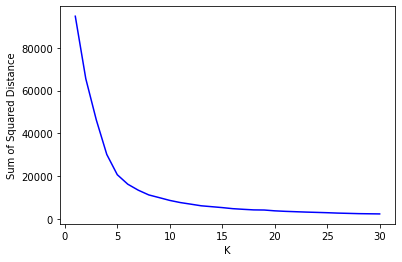

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 31)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 500)
    km.fit(df.iloc[:,:-1])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220801_1625]CREATED elbow가 존재하지 않음 -> 활용 불가

## K-means 모델 생성

In [7]:
def cal_accuracy(target, cluster):
    ct = pd.crosstab(target, cluster)
    accuracy = 0
    for i in range(ct.iloc[:, 0].count()):
        accuracy += ct.iloc[i,:].max() / ct.iloc[i,:].sum()
    return accuracy / ct.iloc[:, 0].count()
#[220812_1340]CREATED 비지도학습에서의 정확도 계산 함수 생성

### 교차 검증

* 검증 데이터셋 생성x(학습 데이터량의 변화에 따른 모델의 정확도 변화 분석에 용이)

In [129]:
from sklearn.cluster import KMeans
data = df.iloc[:,:-1]
label = df['target']
#[220812_1141]CREATED 교차 검증을 위한 모델, 데이터, 라벨 생성
cv = 1
#[220812_2338]NOTED 검증 데이터셋 개수
start_index = 0
accuracy = []
for i in range(cv):
    X_test = data.iloc[start_index:start_index + len(df.index) // cv, :-2]
    y_test = label[start_index:start_index + len(df.index) // cv]
    kmeans = KMeans(n_clusters = len(y_test.unique()), max_iter = 1000)
    kmeans.fit(X_test)
    accuracy.append(np.round(cal_accuracy(y_test, kmeans.labels_), 4))
    #[220812_2338]CREATED crosstab에 새로운 데이터를 넣을 때는 리스트로 넣기
    start_index += (len(df.index) // cv)
print('교차 검증별 정확도:', accuracy)
print('평균 검증 정확도:', np.round(np.mean(accuracy), 4))
#[220813_1117]NOTED 검증 데이터셋이 없고, 학습 데이터셋의 수는 cv값과 반비례하기 때문에, cv값이 증가함에 따라 정확도는 감소
#[220813_1117]NOTED 학습 데이터 수가 줄어듬에 따라 모델의 정확도 변화율을 분석하기에 용이

교차 검증별 정확도: [0.9891]
평균 검증 정확도: 0.9891


* 검증 데이터셋 생성

In [113]:
from sklearn.cluster import KMeans
data = df.iloc[:,:-1]
label = df['target']
#[220812_1141]CREATED 교차 검증을 위한 모델, 데이터, 라벨 생성
cv = 5
#[220812_2338]NOTED 검증 데이터셋 개수
start_index = 0
accuracy = []
for i in range(cv):
    X_train, X_test = pd.concat([data.iloc[0:start_index, :-1], data.iloc[start_index + len(df.index) // cv:, :-1]]), data.iloc[start_index:start_index + len(df.index) // cv, :-1]
    y_train, y_test = pd.concat([label[0:start_index], label[start_index + len(df.index) // cv:]]), label[start_index:start_index + len(df.index) // cv] 
    #[220813_1108]CREATED X_test, y_test: 검증 데이터셋
    kmeans = KMeans(n_clusters = len(y_train.unique()), max_iter = 1000)
    kmeans.fit(X_train)
    accuracy.append(np.round(cal_accuracy(y_train, kmeans.labels_), 4))
    #[220812_2338]CREATED crosstab에 새로운 데이터를 넣을 때는 리스트로 넣기
    #[220813_1108]CREATED predict()를 통해 새로운 데이터셋에 대한 cluster 레이블을 출력하여 정답지인 y_test와 비교한다.
    start_index += (len(df.index) // cv)
print('교차 검증별 정확도:', accuracy)
print('평균 검증 정확도:', np.round(np.mean(accuracy), 4))

교차 검증별 정확도: [0.915, 0.9761, 0.984, 0.985, 0.9862]
평균 검증 정확도: 0.9693


In [26]:
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

kmeans = KMeans(n_clusters=9, init='k-means++', max_iter=500)
kmeans.fit(df.iloc[:,:-1])
df['cluster'] = kmeans.labels_
print(kmeans.labels_)

[7 7 7 7 8 8 8 8 8 8 8 8 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 8 8 8 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]


In [27]:
df.groupby(['target', 'cluster'])['AAA'].count()

target  cluster
0       0          101
        8            3
1       8            3
2       6           10
3       1          111
        7            1
4       3           53
        6            1
5       8            4
6       2           91
        7            3
        8            1
7       5           10
8       4           24
Name: AAA, dtype: int64

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca_transformed = pca.fit_transform(df.iloc[:, :-2])

df['pca_x'] = pca_transformed[:, 0]
df['pca_y'] = pca_transformed[:, 1]
df.head()

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCC,TCT,TTA,TTG,TTC,TTT,target,cluster,pca_x,pca_y
0,5,3,3,8,3,7,6,6,12,2,...,3,8,11,8,7,9,6,8,-8.009834,4.116119
1,5,3,2,7,3,10,5,6,10,2,...,4,8,6,6,10,7,6,8,-7.519331,5.244852
2,5,3,2,7,3,10,5,6,10,2,...,4,8,6,6,10,7,6,8,-7.519331,5.244852
3,16,4,6,11,6,3,7,3,5,0,...,1,4,9,3,6,17,3,8,1.407668,8.211529
4,7,3,10,15,3,7,13,4,9,1,...,6,7,18,8,5,21,0,6,-0.553358,3.014074


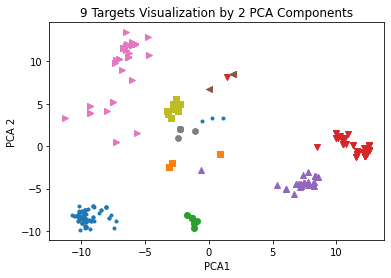

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.xlabel('PCA1')
plt.ylabel('PCA 2')
plt.title('9 Targets Visualization by 2 PCA Components')
plt.show()

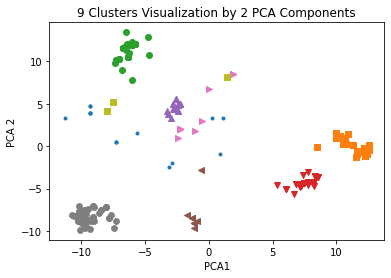

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)
    
plt.xlabel('PCA1')
plt.ylabel('PCA 2')
plt.title('9 Clusters Visualization by 2 PCA Components')
plt.show()